In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tensorflow as tf
import random

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam


In [2]:
def set_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

set_seed(42)

In [3]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  "font.size": 14,
  "grid.alpha": 0.25})

### Function declarations

In [4]:
def plot_time_series(x, y, xlabel="Time", ylabel="Value", figsize=(14, 4), 
                     use_weekday_locator=False, use_year_locator=True, title=None, 
                     add_mark_at=None):
  fig, ax = plt.subplots(figsize=figsize)

  ax.plot(x, y)

  if use_weekday_locator:
    formatter = mdates.DateFormatter("%d-%b")
    locator = mdates.DayLocator(interval=14)
  elif use_year_locator:
    formatter = mdates.DateFormatter("%d/%m/%Y")
    # locator = mdates.YearLocator(base=1)
    # formatter = mdates.DateFormatter("%Y")
    locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 1))

  ax.xaxis.set_major_formatter(formatter)
  ax.xaxis.set_major_locator(locator)
  
  if add_mark_at:
    x_loc, cycle_length = add_mark_at
    ax.plot(x[x_loc::cycle_length], y[x_loc::cycle_length], linestyle="None",
      marker='o', markerfacecolor='w', markeredgewidth=2, 
      markeredgecolor="tab:blue")

  ax.grid("on")
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)

  if title is not None:
    ax.set_title(title)

  if use_year_locator or use_weekday_locator:
    for j, label in enumerate(ax.get_xticklabels()):
      label.set_rotation(40)
      label.set_size(8)
      label.set_horizontalalignment('right')

  plt.show(fig)

In [5]:
def plot_time_series_data_window(
  x, y, xlabel="Time", ylabel="Value", figsize=(14, 4), 
  use_weekday_locator=False, use_year_locator=True, title=None, 
  add_mark_at=None, input_width=24, label_width=24):

  fig, ax = plt.subplots(figsize=figsize)

  num_of_rows = len(x)
  data_window_size = input_width + label_width
  num_of_data_window = num_of_rows // data_window_size
  input_color = "tab:blue" 
  label_color = "tab:orange" 
  
  for i in range(num_of_data_window):
    start_width_idx = i*data_window_size
    end_width_idx = i*data_window_size + input_width
    ax.plot(x.iloc[start_width_idx:end_width_idx], 
            y.iloc[start_width_idx:end_width_idx], color=input_color, 
            marker="s")
    
    start_label_idx = i*data_window_size + input_width
    end_label_idx = i*data_window_size + input_width + label_width
    ax.plot(x.iloc[start_label_idx:end_label_idx], 
            y.iloc[start_label_idx:end_label_idx], color=label_color, 
            marker="x")
        
  if use_weekday_locator:
    formatter = mdates.DateFormatter("%d-%b-%Y")
    locator = mdates.DayLocator(interval=14)
  elif use_year_locator:
    formatter = mdates.DateFormatter("%d/%m/%Y")
    # locator = mdates.YearLocator(base=1)
    # formatter = mdates.DateFormatter("%Y")
    locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 1))

  ax.xaxis.set_major_formatter(formatter)
  ax.xaxis.set_major_locator(locator)
  
  if add_mark_at:
    x_loc, cycle_length = add_mark_at
    ax.plot(x[x_loc::cycle_length], y[x_loc::cycle_length], linestyle="None",
      marker='o', markerfacecolor='w', markeredgewidth=2, 
      markeredgecolor="tab:blue")

  ax.grid("on")
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)

  if title is not None:
    ax.set_title(title)

  if use_year_locator or use_weekday_locator:
    for j, label in enumerate(ax.get_xticklabels()):
      label.set_rotation(40)
      label.set_size(8)
      label.set_horizontalalignment('right')

  plt.show(fig)

### Load

In [6]:
file_path = "./data/CDB THN 2021-2024.csv"
df_cdb = pd.read_csv(file_path)
df_cdb["Tgl. Mohon"] = pd.to_datetime(df_cdb["Tgl. Mohon"], format="%d/%m/%Y")
df_cdb["Tgl. Lahir"] = pd.to_datetime(df_cdb["Tgl. Lahir"], format="%d/%m/%Y")
df_cdb

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus
0,2021-01-02,MULKAN,JL AL MAKMUR I,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1996-08-18,Wiraswasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,LD0
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,2003-04-14,Pegawai Swasta-Jasa,"< Rp. 900.000,-",AKADEMI/DIPLOMA,LP0
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1997-02-13,Pegawai Swasta-Pertanian,"Rp. 900.001,- s/d Rp. 1.250.000,-",SARJANA,LPA
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1982-11-16,Pegawai Swasta-Industri,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SLTA/SMU,LP0
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1976-01-17,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,LPA
...,...,...,...,...,...,...,...,...,...,...,...
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,GUNUNGSARI ULU,BALIKPAPAN TENGAH,LAKI-LAKI,1961-01-19,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SARJANA,LP3
6855,2024-08-31,GOMGOM RAULI SIHOMBING,PERUM BDS II,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1980-04-30,IBU RUMAH TANGGA,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ML0


In [7]:
df_cdb_with_initial = df_cdb.copy()
df_cdb_with_initial["initial Varian Plus"] = df_cdb_with_initial["Varian Plus"].apply(lambda x: x[0])
df_cdb_with_initial

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus,initial Varian Plus
0,2021-01-02,MULKAN,JL AL MAKMUR I,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1996-08-18,Wiraswasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,LD0,L
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,2003-04-14,Pegawai Swasta-Jasa,"< Rp. 900.000,-",AKADEMI/DIPLOMA,LP0,L
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1997-02-13,Pegawai Swasta-Pertanian,"Rp. 900.001,- s/d Rp. 1.250.000,-",SARJANA,LPA,L
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1982-11-16,Pegawai Swasta-Industri,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SLTA/SMU,LP0,L
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1976-01-17,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,LPA,L
...,...,...,...,...,...,...,...,...,...,...,...,...
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0,M
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0,M
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,GUNUNGSARI ULU,BALIKPAPAN TENGAH,LAKI-LAKI,1961-01-19,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SARJANA,LP3,L
6855,2024-08-31,GOMGOM RAULI SIHOMBING,PERUM BDS II,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1980-04-30,IBU RUMAH TANGGA,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ML0,M


In [8]:
df_cdb_with_tipe = df_cdb_with_initial.copy()
def tipe_customer(row):
    if row[["Gender", "Tgl. Lahir", "Pekerjaan", "Pengeluaran", "Pendidikan"]].isnull().any():
        return "INSTANSI LUAR"
    else:
        return "INDIVIDU"

df_cdb_with_tipe["Tipe Pembeli"] = df_cdb_with_tipe.apply(tipe_customer, axis=1)
df_cdb_with_tipe["Umur"] = (pd.to_datetime("today") - df_cdb_with_tipe["Tgl. Lahir"]).dt.days // 365

df_cdb_individu = df_cdb_with_tipe[df_cdb_with_tipe["Tipe Pembeli"] == "INDIVIDU"].copy()
df_cdb_individu

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus,initial Varian Plus,Tipe Pembeli,Umur
0,2021-01-02,MULKAN,JL AL MAKMUR I,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1996-08-18,Wiraswasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,LD0,L,INDIVIDU,28
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,2003-04-14,Pegawai Swasta-Jasa,"< Rp. 900.000,-",AKADEMI/DIPLOMA,LP0,L,INDIVIDU,22
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1997-02-13,Pegawai Swasta-Pertanian,"Rp. 900.001,- s/d Rp. 1.250.000,-",SARJANA,LPA,L,INDIVIDU,28
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1982-11-16,Pegawai Swasta-Industri,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SLTA/SMU,LP0,L,INDIVIDU,42
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1976-01-17,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,LPA,L,INDIVIDU,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0,M,INDIVIDU,20
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0,M,INDIVIDU,47
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,GUNUNGSARI ULU,BALIKPAPAN TENGAH,LAKI-LAKI,1961-01-19,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SARJANA,LP3,L,INDIVIDU,64
6855,2024-08-31,GOMGOM RAULI SIHOMBING,PERUM BDS II,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1980-04-30,IBU RUMAH TANGGA,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ML0,M,INDIVIDU,44


In [9]:
df_H = df_cdb_individu[df_cdb_individu["initial Varian Plus"] == "H"].copy()
df_H

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus,initial Varian Plus,Tipe Pembeli,Umur
12,2021-01-05,JULI HARJANTO,JL BLORA,KLANDASAN ILIR,BALIKPAPAN KOTA,LAKI-LAKI,1977-07-18,Pegawai Swasta-Jasa,"< Rp. 900.000,-",SLTA/SMU,HZ3,H,INDIVIDU,47
13,2021-01-06,"DHINA R. AGUSTIANA DA, SE",JL MASJID AR RAUDAH I,GUNUNG BAHAGIA,BALIKPAPAN SELATAN,PEREMPUAN,1974-08-13,IBU RUMAH TANGGA,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SARJANA,HWC,H,INDIVIDU,50
24,2021-01-07,AHMAD HABIBI HARAHAP,JL DAKSA TIMUR I,SEPINGGAN,BALIKPAPAN SELATAN,LAKI-LAKI,1995-04-30,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,HDN,H,INDIVIDU,29
31,2021-01-07,GALIH PUTRO WICAKSONO,JL JEND SUDIRMAN ASPOL STAL KUDA,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1993-05-26,TNI/POLRI,"< Rp. 900.000,-",AKADEMI/DIPLOMA,HZ3,H,INDIVIDU,31
37,2021-01-09,VELIANA FEBRIANTI,JL GUNUNG GEMBIRA,BARU ILIR,BALIKPAPAN BARAT,PEREMPUAN,1997-02-25,Pegawai Swasta-Perdagangan,"< Rp. 900.000,-",SLTA/SMU,HS2,H,INDIVIDU,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5956,2024-04-06,ERNIE DIANA NUR,JL. SIDOMULYO,MARGO MULYO,BALIKPAPAN BARAT,PEREMPUAN,1977-08-14,IBU RUMAH TANGGA,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,HDP,H,INDIVIDU,47
6330,2024-06-06,ERNI,JL. WOLTET MONGINSIDI GG. MACAN,BARU ULU,BALIKPAPAN BARAT,PEREMPUAN,1977-07-07,Wiraswasta-Jasa,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,HD7,H,INDIVIDU,47
6351,2024-06-10,ZULFIKAR,JL TELINDUNG,BATU AMPAR,BALIKPAPAN UTARA,LAKI-LAKI,1988-02-07,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,HJ9,H,INDIVIDU,37
6501,2024-07-08,JOSUA,JL JENDRAL SUDIRMAN,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,2000-07-22,Pegawai Swasta-Jasa,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,HDN,H,INDIVIDU,24


In [10]:
df_H_count = df_H[["Tgl. Mohon"]].copy()
df_H_count["count"] = 1.
df_H_count = df_H_count.groupby("Tgl. Mohon").agg("count").reset_index()
df_H_count["cumulative_sum"] = df_H_count["count"].cumsum()
df_H_count

,Tgl. Mohon,count,cumulative_sum
0,2021-01-05,1,1
1,2021-01-06,1,2
2,2021-01-07,2,4
3,2021-01-09,1,5
4,2021-01-11,1,6
...,...,...,...
291,2024-04-06,1,438
292,2024-06-06,1,439
293,2024-06-10,1,440
294,2024-07-08,1,441


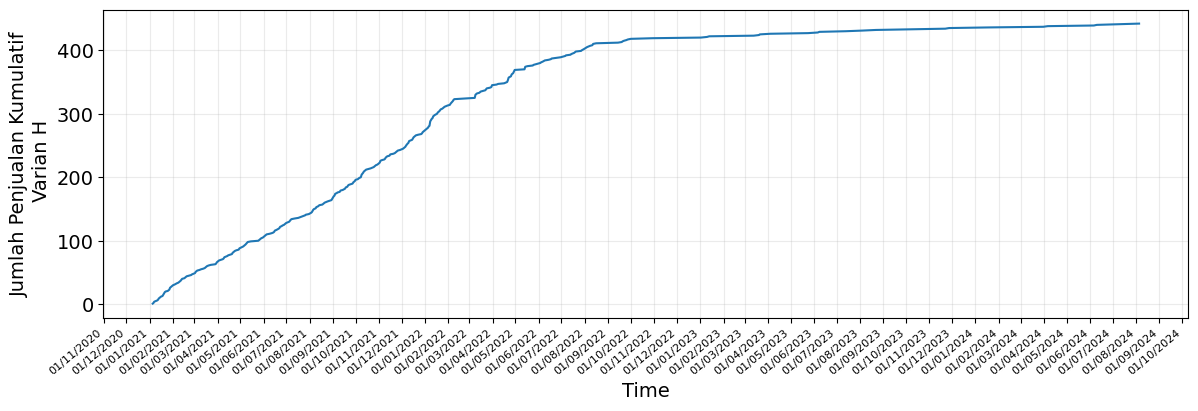

In [11]:
plot_time_series(df_H_count["Tgl. Mohon"], df_H_count["cumulative_sum"], use_year_locator=True, 
                  ylabel="Jumlah Penjualan Kumulatif\n Varian H")

## Feature engineering

In [12]:
df_H_count.describe()

,Tgl. Mohon,count,cumulative_sum
count,296,296.000000,296.000000
mean,2021-12-01 18:04:51.891891968,1.493243,221.891892
min,2021-01-05 00:00:00,1.000000,1.000000
25%,2021-06-02 06:00:00,1.000000,107.250000
50%,2021-10-23 00:00:00,1.000000,215.000000
75%,2022-04-06 12:00:00,2.000000,346.250000
max,2024-08-05 00:00:00,7.000000,442.000000
std,NaN,0.859615,135.132434


- Karena `count` mayoritas tanggal hanya memiliki 1 permohonan, dan hanya sebagian kecil yang mengalami lonjakan signifikan seperti 7.
- Kolom `cumulative_sum` tidak cocok untuk digunakan langsung dalam prediksi karena secara definisi selalu meningkat namun bisa digunakan untuk membuat fitur baru seperti jumlah permohonan dalam periode tertentu (sliding window) atau perubahan kumulatif
- Encoding waktu ke bentuk sin dan cos agar model dapat mengenali pola musiman

yang dilakukan
1. Mengurutkan data berdasarkan tanggal permohonan untuk rolling window
2. Menambah fitur baru:
    - `rolling_7days` untuk jumlah permohonan dalam 7 hari terakhir
    - `delta_count` untuk melihat selisih jumlah permohonan di hari sebelumnya
    - `month` untuk melihat pola data lebih banyak di bulan apa
    - `weekday` untuk melihat pola data lebih banyak di awal atau alhir minggu
3. Menambah fitur baru
    - `month_sin` dan `month_cos` untuk merepresentasikan nilai bulan Jan = 1 sampai Des = 12 secara periodik (siklikal), misalnya untuk menangani bulan Des (12) ke Jan (1) berdekatan dalam waktu, namun secara numerik 12 dan 1 terlihat jauh karena model tidak mengerti bahwa bulan itu berulang
    - `weekday_sin` dan `weekday_cos` untuk merepresentasikan hari dalam mingguan Senin = 0, Minggu = 6 secara siklikal
sehingga dengan sinus dan cosinus dapat membuat cyclical encoding (lingkaran) agar model bisa menangkap pola berulang karena berada pada sudut yang mirip di lingkaran. 

### Add Fitur

In [13]:
df_H_rolling = df_H_count.copy()
df_H_rolling = df_H_rolling.sort_values("Tgl. Mohon").reset_index(drop=True)

df_H_rolling["rolling_7days"] = df_H_rolling["count"].rolling(window=7, min_periods=1).sum()
# df_H_rolling["rolling_std_7d"] = df_H_rolling["count"].rolling(window=7, min_periods=1).std().fillna(0)
df_H_rolling['delta_count'] = df_H_rolling['count'].diff().fillna(0)

df_H_rolling['month'] = df_H_rolling['Tgl. Mohon'].dt.month
df_H_rolling['weekday'] = df_H_rolling['Tgl. Mohon'].dt.weekday
df_H_rolling

,Tgl. Mohon,count,cumulative_sum,rolling_7days,delta_count,month,weekday
0,2021-01-05,1,1,1.0,0.0,1,1
1,2021-01-06,1,2,2.0,0.0,1,2
2,2021-01-07,2,4,4.0,1.0,1,3
3,2021-01-09,1,5,5.0,-1.0,1,5
4,2021-01-11,1,6,6.0,0.0,1,0
...,...,...,...,...,...,...,...
291,2024-04-06,1,438,7.0,0.0,4,5
292,2024-06-06,1,439,7.0,0.0,6,3
293,2024-06-10,1,440,7.0,0.0,6,0
294,2024-07-08,1,441,7.0,0.0,7,0


### Encoding untuk waktu ke data kategori harian (sin cos)

3. Menambah fitur baru
    - `month_sin` dan `month_cos` untuk merepresentasikan nilai bulan Jan = 1 sampai Des = 12 secara periodik (siklikal), misalnya untuk menangani bulan Des (12) ke Jan (1) berdekatan dalam waktu, namun secara numerik 12 dan 1 terlihat jauh karena model tidak mengerti bahwa bulan itu berulang
    - `weekday_sin` dan `weekday_cos` untuk merepresentasikan hari dalam mingguan Senin = 0, Minggu = 6 secara siklikal
sehingga dengan sinus dan cosinus dapat membuat cyclical encoding (lingkaran) agar model bisa menangkap pola berulang karena berada pada sudut yang mirip di lingkaran. 

In [14]:
df_H_rolling['month_sin'] = np.sin(2 * np.pi * df_H_rolling['month'] / 12)
df_H_rolling['month_cos'] = np.cos(2 * np.pi * df_H_rolling['month'] / 12)

df_H_rolling['weekday_sin'] = np.sin(2 * np.pi * df_H_rolling['weekday'] / 7)
df_H_rolling['weekday_cos'] = np.cos(2 * np.pi * df_H_rolling['weekday'] / 7)
df_H_rolling

,Tgl. Mohon,count,cumulative_sum,rolling_7days,delta_count,month,weekday,month_sin,month_cos,weekday_sin,weekday_cos
0,2021-01-05,1,1,1.0,0.0,1,1,5.000000e-01,0.866025,0.781831,0.623490
1,2021-01-06,1,2,2.0,0.0,1,2,5.000000e-01,0.866025,0.974928,-0.222521
2,2021-01-07,2,4,4.0,1.0,1,3,5.000000e-01,0.866025,0.433884,-0.900969
3,2021-01-09,1,5,5.0,-1.0,1,5,5.000000e-01,0.866025,-0.974928,-0.222521
4,2021-01-11,1,6,6.0,0.0,1,0,5.000000e-01,0.866025,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
291,2024-04-06,1,438,7.0,0.0,4,5,8.660254e-01,-0.500000,-0.974928,-0.222521
292,2024-06-06,1,439,7.0,0.0,6,3,1.224647e-16,-1.000000,0.433884,-0.900969
293,2024-06-10,1,440,7.0,0.0,6,0,1.224647e-16,-1.000000,0.000000,1.000000
294,2024-07-08,1,441,7.0,0.0,7,0,-5.000000e-01,-0.866025,0.000000,1.000000


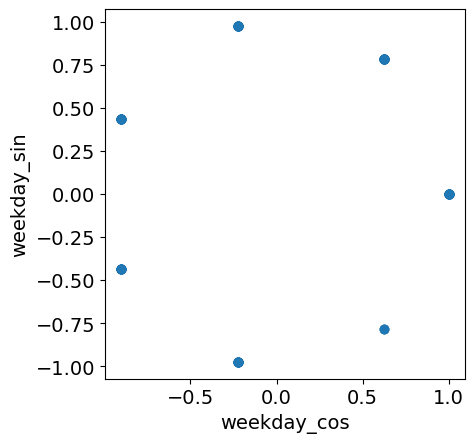

In [15]:
n_sample = 200   # randomly sample from the df_H_rolling

fig, ax = plt.subplots()

sampled_data = df_H_rolling.sample(n_sample)
ax.plot(sampled_data["weekday_cos"], sampled_data["weekday_sin"], linestyle="none",
        marker="o")

ax.set_aspect("equal")
ax.set_xlabel("weekday_cos")
ax.set_ylabel("weekday_sin")
plt.show(fig)

In [16]:
df_H_rolling.describe()

,Tgl. Mohon,count,cumulative_sum,rolling_7days,delta_count,month,weekday,month_sin,month_cos,weekday_sin,weekday_cos
count,296,296.000000,296.000000,296.000000,296.00000,296.000000,296.000000,2.960000e+02,2.960000e+02,296.000000,296.000000
mean,2021-12-01 18:04:51.891891968,1.493243,221.891892,10.381757,0.00000,5.827703,2.398649,6.204738e-02,-1.028891e-02,0.152789,-0.019153
min,2021-01-05 00:00:00,1.000000,1.000000,1.000000,-4.00000,1.000000,0.000000,-1.000000e+00,-1.000000e+00,-0.974928,-0.900969
25%,2021-06-02 06:00:00,1.000000,107.250000,8.000000,0.00000,3.000000,1.000000,-5.000000e-01,-5.000000e-01,-0.433884,-0.900969
50%,2021-10-23 00:00:00,1.000000,215.000000,10.000000,0.00000,6.000000,2.000000,1.224647e-16,-6.123234e-17,0.433884,-0.222521
75%,2022-04-06 12:00:00,2.000000,346.250000,12.000000,0.00000,9.000000,4.000000,8.660254e-01,8.660254e-01,0.781831,0.623490
max,2024-08-05 00:00:00,7.000000,442.000000,21.000000,6.00000,12.000000,6.000000,1.000000e+00,1.000000e+00,0.974928,1.000000
std,NaN,0.859615,135.132434,2.973249,1.13197,3.433737,1.778363,7.139302e-01,6.998030e-01,0.675325,0.723557


In [17]:
# Menghitung korelasi antar kolom numerik
corr_matrix = df_H_rolling.corr()
print(corr_matrix)


                Tgl. Mohon     count  cumulative_sum  rolling_7days  \
Tgl. Mohon        1.000000 -0.083145        0.910274      -0.104831   
count            -0.083145  1.000000        0.001307       0.444661   
cumulative_sum    0.910274  0.001307        1.000000       0.083688   
rolling_7days    -0.104831  0.444661        0.083688       1.000000   
delta_count      -0.004014  0.658417       -0.005474      -0.018129   
month             0.202154 -0.053798        0.233817      -0.037364   
weekday          -0.045167  0.108206       -0.033886       0.010868   
month_sin        -0.183288  0.090958       -0.185950       0.140295   
month_cos        -0.160552  0.113010       -0.136381       0.146615   
weekday_sin       0.005768 -0.071572        0.027143      -0.014110   
weekday_cos       0.080221 -0.086630        0.040390      -0.070483   

                delta_count     month   weekday  month_sin  month_cos  \
Tgl. Mohon        -0.004014  0.202154 -0.045167  -0.183288  -0.160552   
c

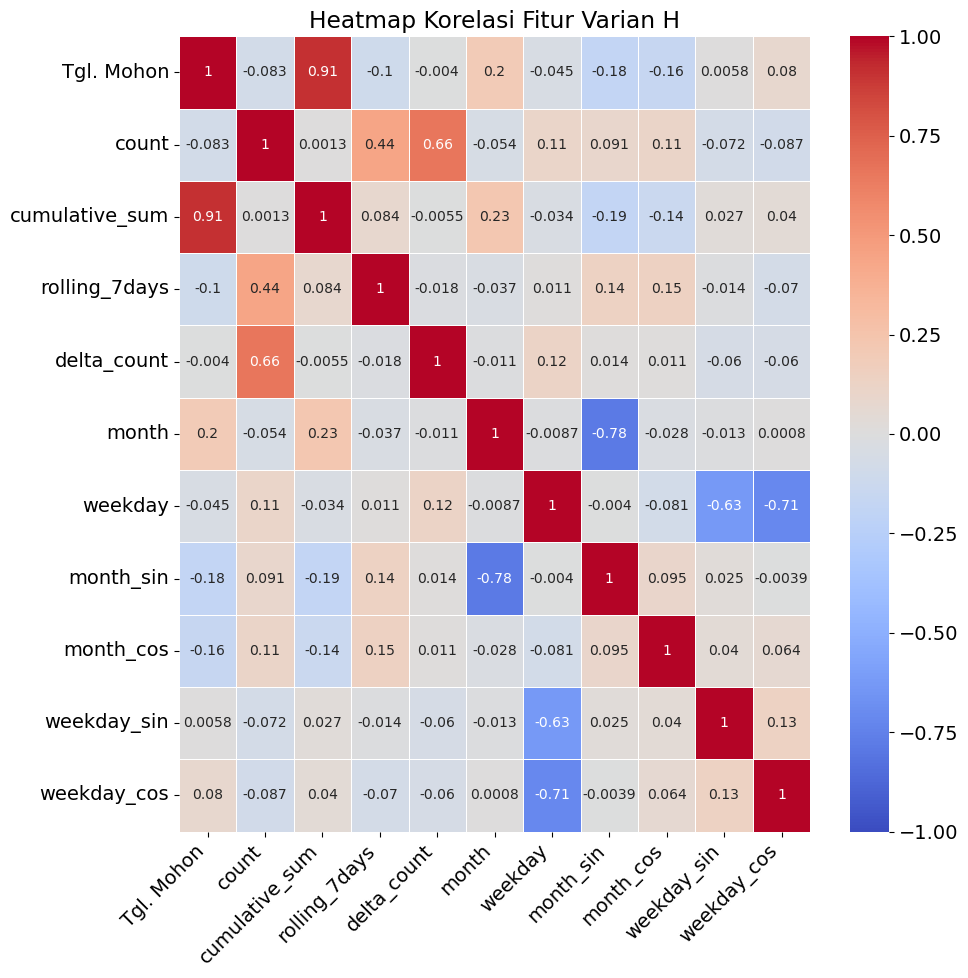

In [18]:
plt.figure(figsize=(10, 10))
sns.heatmap(
    corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5,
    vmin=-1, vmax=1, annot_kws={"size": 10})
plt.title("Heatmap Korelasi Fitur Varian H")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()


### Data Splitting

In [19]:
n_data = len(df_H_rolling)

# Split 70:20:10 (train:validation:test)
idx_train = int(n_data * 0.7)
idx_test = int(n_data * 0.9)

train_df = df_H_rolling[:idx_train].copy()
val_df = df_H_rolling[idx_train:idx_test].copy()
test_df = df_H_rolling[idx_test:].copy()

print(f"len(train, val, test): {len(train_df), len(val_df), len(test_df)}")

len(train, val, test): (207, 59, 30)


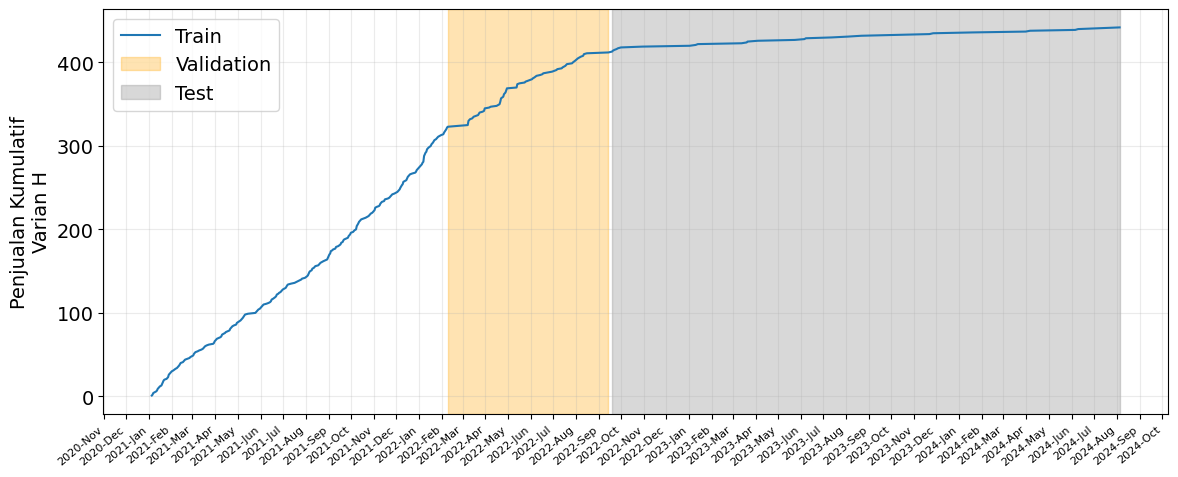

In [20]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(df_H_rolling['Tgl. Mohon'], df_H_rolling["cumulative_sum"], label="Train", color="tab:blue")

# add forecast area
ax.axvspan(val_df['Tgl. Mohon'].iloc[0], val_df['Tgl. Mohon'].iloc[-1], 
           color="orange", alpha=0.3, label="Validation")
ax.axvspan(test_df['Tgl. Mohon'].iloc[0], test_df['Tgl. Mohon'].iloc[-1], 
           color="gray", alpha=0.3, label="Test")

ax.grid("on")
ax.set_ylabel("Penjualan Kumulatif\nVarian H")

# formatter = mdates.DateFormatter("%Y")
formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 1))
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)

for label in ax.get_xticklabels():
    label.set_rotation(40)
    label.set_fontsize(8)
    label.set_horizontalalignment('right')

ax.legend()

plt.tight_layout()
plt.show()

In [21]:
train_df

,Tgl. Mohon,count,cumulative_sum,rolling_7days,delta_count,month,weekday,month_sin,month_cos,weekday_sin,weekday_cos
0,2021-01-05,1,1,1.0,0.0,1,1,0.500000,0.866025,0.781831,0.623490
1,2021-01-06,1,2,2.0,0.0,1,2,0.500000,0.866025,0.974928,-0.222521
2,2021-01-07,2,4,4.0,1.0,1,3,0.500000,0.866025,0.433884,-0.900969
3,2021-01-09,1,5,5.0,-1.0,1,5,0.500000,0.866025,-0.974928,-0.222521
4,2021-01-11,1,6,6.0,0.0,1,0,0.500000,0.866025,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
202,2022-01-31,2,313,13.0,0.0,1,0,0.500000,0.866025,0.000000,1.000000
203,2022-02-03,1,314,12.0,-1.0,2,3,0.866025,0.500000,0.433884,-0.900969
204,2022-02-04,2,316,12.0,1.0,2,4,0.866025,0.500000,-0.433884,-0.900969
205,2022-02-07,4,320,13.0,2.0,2,0,0.866025,0.500000,0.000000,1.000000


scaling data

In [22]:
column_for_scaling = ["count", "cumulative_sum", "rolling_7days", "delta_count", "month", 
                    "weekday", "month_sin", "month_cos", "weekday_sin", "weekday_cos"]

# Define a scaler object
scaler_obj = MinMaxScaler()
scaler_obj.fit(train_df[column_for_scaling])

# Scaling train, val, test
train_scale_df_h = train_df.copy()
val_scale_df_h = val_df.copy()
test_scale_df_h = test_df.copy()

train_scale_df_h[column_for_scaling] = scaler_obj.transform(train_scale_df_h[column_for_scaling])
val_scale_df_h[column_for_scaling] = scaler_obj.transform(val_scale_df_h[column_for_scaling])
test_scale_df_h[column_for_scaling] = scaler_obj.transform(test_scale_df_h[column_for_scaling])

display(train_scale_df_h.head())
display(val_scale_df_h.head())
display(test_scale_df_h.head())

,Tgl. Mohon,count,cumulative_sum,rolling_7days,delta_count,month,weekday,month_sin,month_cos,weekday_sin,weekday_cos
0,2021-01-05,0.000000,0.000000,0.00,0.333333,0.0,0.166667,0.75,0.933013,0.900969,8.019377e-01
1,2021-01-06,0.000000,0.003115,0.05,0.333333,0.0,0.333333,0.75,0.933013,1.000000,3.568959e-01
2,2021-01-07,0.166667,0.009346,0.15,0.444444,0.0,0.500000,0.75,0.933013,0.722521,5.551115e-17
3,2021-01-09,0.000000,0.012461,0.20,0.222222,0.0,0.833333,0.75,0.933013,0.000000,3.568959e-01
4,2021-01-11,0.000000,0.015576,0.25,0.333333,0.0,0.000000,0.75,0.933013,0.500000,1.000000e+00


,Tgl. Mohon,count,cumulative_sum,rolling_7days,delta_count,month,weekday,month_sin,month_cos,weekday_sin,weekday_cos
207,2022-02-09,0.000000,1.003115,0.65,0.222222,0.090909,0.333333,0.933013,0.75,1.000000,3.568959e-01
208,2022-03-08,0.166667,1.009346,0.65,0.444444,0.181818,0.166667,1.000000,0.50,0.900969,8.019377e-01
209,2022-03-09,0.666667,1.024922,0.80,0.666667,0.181818,0.333333,1.000000,0.50,1.000000,3.568959e-01
210,2022-03-10,0.000000,1.028037,0.80,-0.111111,0.181818,0.500000,1.000000,0.50,0.722521,5.551115e-17
211,2022-03-11,0.000000,1.031153,0.75,0.333333,0.181818,0.666667,1.000000,0.50,0.277479,0.000000e+00


,Tgl. Mohon,count,cumulative_sum,rolling_7days,delta_count,month,weekday,month_sin,month_cos,weekday_sin,weekday_cos
266,2022-09-19,0.0,1.283489,0.35,0.333333,0.727273,0.000000,0.0,0.5,0.500000,1.000000e+00
267,2022-09-20,0.0,1.286604,0.35,0.333333,0.727273,0.166667,0.0,0.5,0.900969,8.019377e-01
268,2022-09-22,0.0,1.289720,0.35,0.333333,0.727273,0.500000,0.0,0.5,0.722521,5.551115e-17
269,2022-09-25,0.0,1.292835,0.35,0.333333,0.727273,1.000000,0.0,0.5,0.099031,8.019377e-01
270,2022-09-27,0.0,1.295950,0.30,0.333333,0.727273,0.166667,0.0,0.5,0.900969,8.019377e-01


In [23]:
train_scale_df_h.to_csv("./data/train_scale_h.csv", index=False)
val_scale_df_h.to_csv("./data/val_scale_h.csv", index=False)
test_scale_df_h.to_csv("./data/test_scale_h.csv", index=False)

In [24]:
dataset_section = ['train', 'val', 'test']
dataset = {}
for section in dataset_section:
  dataset[f"{section}_scale_df_h"] = pd.read_csv(f"./data/{section}_scale_h.csv",
                                                parse_dates=["Tgl. Mohon"])
dataset["train_scale_df_h"]

,Tgl. Mohon,count,cumulative_sum,rolling_7days,delta_count,month,weekday,month_sin,month_cos,weekday_sin,weekday_cos
0,2021-01-05,0.000000,0.000000,0.00,0.333333,0.000000,0.166667,0.750000,0.933013,0.900969,8.019377e-01
1,2021-01-06,0.000000,0.003115,0.05,0.333333,0.000000,0.333333,0.750000,0.933013,1.000000,3.568959e-01
2,2021-01-07,0.166667,0.009346,0.15,0.444444,0.000000,0.500000,0.750000,0.933013,0.722521,5.551115e-17
3,2021-01-09,0.000000,0.012461,0.20,0.222222,0.000000,0.833333,0.750000,0.933013,0.000000,3.568959e-01
4,2021-01-11,0.000000,0.015576,0.25,0.333333,0.000000,0.000000,0.750000,0.933013,0.500000,1.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...
202,2022-01-31,0.166667,0.971963,0.60,0.333333,0.000000,0.000000,0.750000,0.933013,0.500000,1.000000e+00
203,2022-02-03,0.000000,0.975078,0.55,0.222222,0.090909,0.500000,0.933013,0.750000,0.722521,5.551115e-17
204,2022-02-04,0.166667,0.981308,0.55,0.444444,0.090909,0.666667,0.933013,0.750000,0.277479,0.000000e+00
205,2022-02-07,0.500000,0.993769,0.60,0.555556,0.090909,0.000000,0.933013,0.750000,0.500000,1.000000e+00


#### Fluktuasi nilai `rolling_7days`

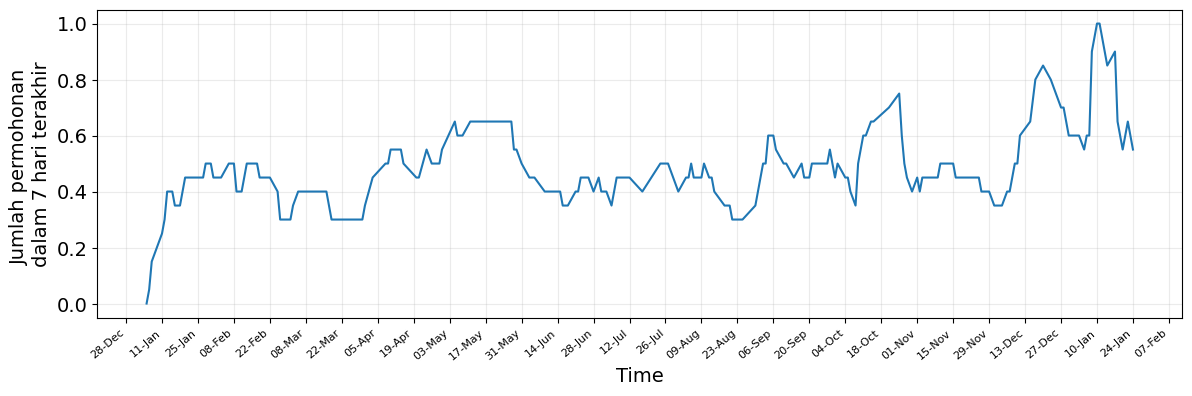

In [25]:
num_of_rows = 200
train_scale_df_j_selected = dataset["train_scale_df_h"]
plot_time_series(train_scale_df_j_selected.iloc[:num_of_rows]["Tgl. Mohon"], 
                  train_scale_df_j_selected.iloc[:num_of_rows]["rolling_7days"],
                  ylabel="Jumlah permohonan \ndalam 7 hari terakhir",
                  use_weekday_locator=True, use_year_locator=False)

#### Data Windowing

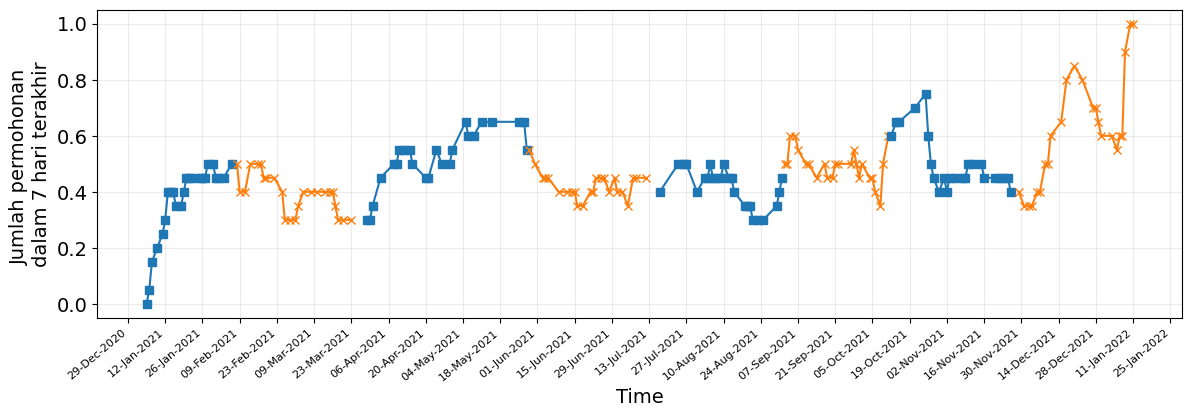

In [26]:
num_of_rows = 200
train_scale_df_h_selected = dataset["train_scale_df_h"]
plot_time_series_data_window(train_scale_df_h_selected.iloc[:num_of_rows]["Tgl. Mohon"], 
                  train_scale_df_h_selected.iloc[:num_of_rows]["rolling_7days"],
                  ylabel="Jumlah permohonan \ndalam 7 hari terakhir",
                  use_weekday_locator=True, use_year_locator=False)

## Model Development

In [27]:
def create_multivariate_sequences(X, y, sequence_length):
    Xs, ys = [], []
    for i in range(sequence_length, len(X)):
        Xs.append(X[i-sequence_length:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

In [28]:
input_columns = [col for col in column_for_scaling if col != "rolling_7days"]
input_columns_autoreg = input_columns + ["rolling_7days"]

feature_col = "rolling_7days"

train_X = train_scale_df_h[input_columns].values
val_X = val_scale_df_h[input_columns].values
test_X = test_scale_df_h[input_columns].values

train_y = train_scale_df_h[feature_col].values
val_y = val_scale_df_h[feature_col].values
test_y = test_scale_df_h[feature_col].values

sequence_length = 10
X_train, y_train = create_multivariate_sequences(train_X, train_y, sequence_length)
X_val, y_val = create_multivariate_sequences(val_X, val_y, sequence_length)

In [29]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(BatchNormalization())
model.add(Dense(8, activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

c:\ProgramData\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 128)        │        70,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,849 (472.07 KB)

 Trainable params: 120,721 (471.57 KB)

 Non-trainable params: 128 (512.00 B)

### Data Training

epoch = 100

In [30]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5)
checkpoint = ModelCheckpoint("best_model.keras", save_best_only=True, monitor='val_loss')

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=16,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 0.5184 - val_loss: 0.0812 - learning_rate: 0.0010
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2541 - val_loss: 0.0573 - learning_rate: 0.0010
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2077 - val_loss: 0.0375 - learning_rate: 0.0010
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.2279 - val_loss: 0.0257 - learning_rate: 0.0010
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.1367 - val_loss: 0.0208 - learning_rate: 0.0010
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0921 - val_loss: 0.0204 - learning_rate: 0.0010
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0570 - val_loss: 0.0212 - learning_rate: 0.0010
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0386 - val_loss: 0.0189 - learning_rate: 0.0010
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0452 - val_loss: 0.0194 - learning_rate: 0.0010
Epoch 10/50
13/13 ━

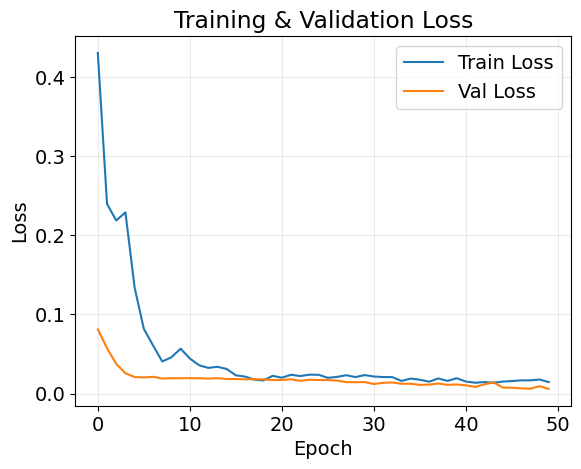

In [31]:
# Visualisasi loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid("on")
plt.show()

### Prediksi `rolling 7 days`

In [32]:
# --- Fungsi Prediksi Autoregressive ---
# Ambil kolom yang digunakan sebagai input ke model
input_columns = [col for col in column_for_scaling if col != "rolling_7days"]

# Ambil sequence terakhir dari validation sebagai seed
last_sequence = val_scale_df_h[input_columns + ["rolling_7days"]].values[-sequence_length:].copy()

# Placeholder untuk menyimpan hasil prediksi (dalam skala yang sudah di-scale)
scaled_preds = []

# Autoregressive loop
for i in range(len(test_df)):
    # Pisahkan input features dan target dari last_sequence
    X_input = last_sequence[:, :-1]  # semua kolom kecuali rolling_7days (fitur input)
    X_input = X_input.reshape(1, sequence_length, len(input_columns))

    # Prediksi rolling_7days berikutnya
    pred_scaled = model.predict(X_input, verbose=0)[0][0]
    scaled_preds.append(pred_scaled)

    # Buat baris baru untuk update sequence
    next_row = last_sequence[-1].copy()
    next_row[:-1] = test_scale_df_h[input_columns].values[i]  # update input fitur
    next_row[-1] = pred_scaled  # rolling_7days hasil prediksi

    # Tambahkan ke sequence (geser window)
    last_sequence = np.vstack([last_sequence[1:], next_row])

In [33]:
# --- Inverse Scaling ---
# Konversi prediksi ke DataFrame agar bisa di-inverse scaling
preds_df_scaled = test_scale_df_h.iloc[:len(scaled_preds)].copy()
preds_df_scaled["rolling_7days"] = scaled_preds

# Inverse transform
preds_inverse = scaler_obj.inverse_transform(preds_df_scaled[column_for_scaling])[:, column_for_scaling.index("rolling_7days")]

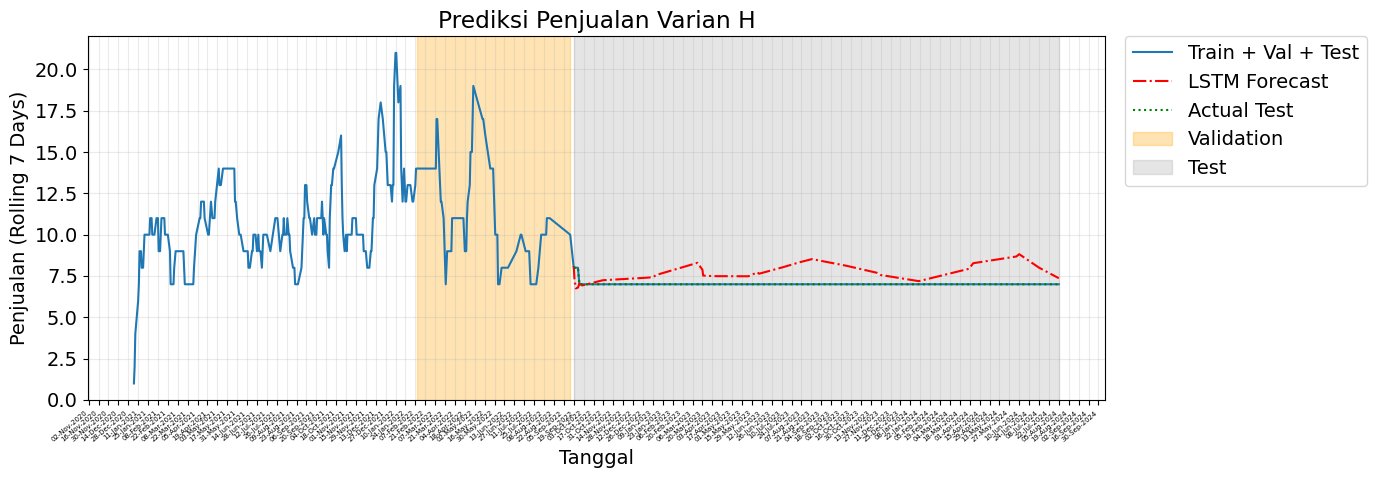

In [34]:
fig, ax = plt.subplots(figsize=(14, 5))

all_dates = pd.concat([train_df, val_df, test_df], ignore_index=True)['Tgl. Mohon']
rolling_values = pd.concat([train_df, val_df, test_df], ignore_index=True)['rolling_7days']

ax.plot(all_dates, rolling_values, label="Train + Val + Test")
ax.plot(test_df["Tgl. Mohon"], preds_inverse, "r-.", label="LSTM Forecast")
ax.plot(test_df["Tgl. Mohon"], test_df["rolling_7days"], "g:", label="Actual Test")

formatter = mdates.DateFormatter("%d-%b-%Y")
locator = mdates.DayLocator(interval=14)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)

ax.set_xlabel("Tanggal")
ax.set_ylabel("Penjualan (Rolling 7 Days)")
ax.set_title("Prediksi Penjualan Varian H")
ax.grid("on")

# Area validation dan test
ax.axvspan(val_df['Tgl. Mohon'].iloc[0], val_df['Tgl. Mohon'].iloc[-1], 
                    color="orange", alpha=0.3, label="Validation")
ax.axvspan(test_df["Tgl. Mohon"].iloc[0], test_df["Tgl. Mohon"].iloc[-1], 
                    color="#808080", alpha=0.2, label="Test")

for label in ax.get_xticklabels():
    label.set_rotation(40)
    label.set_fontsize(5)
    label.set_horizontalalignment('right')

ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()


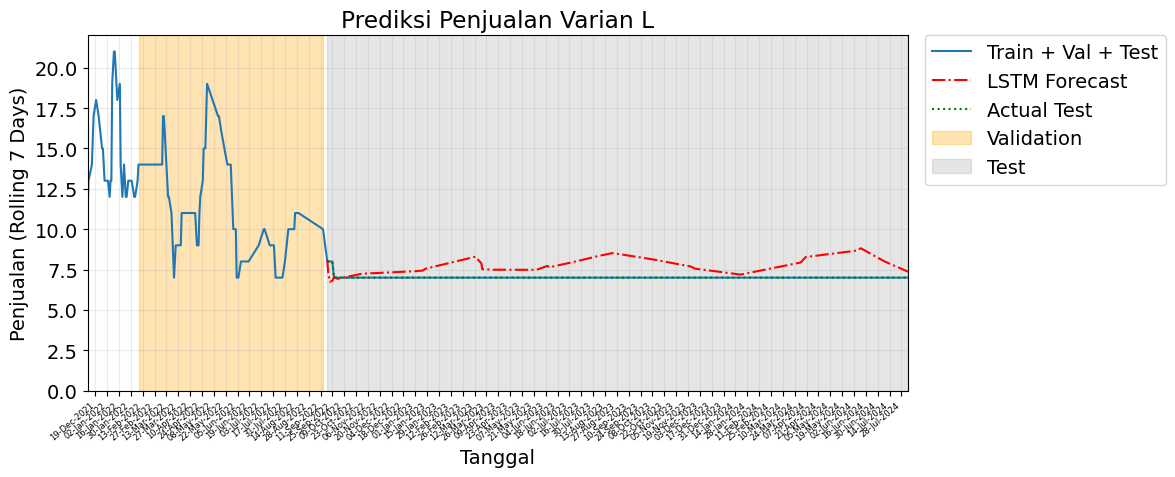

In [35]:
start_idx = 175

xlim = [all_dates.iloc[start_idx], test_df["Tgl. Mohon"].iloc[-1]]

fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(all_dates, rolling_values, label="Train + Val + Test")
ax.plot(test_df["Tgl. Mohon"], preds_inverse, "r-.", label="LSTM Forecast")
ax.plot(test_df["Tgl. Mohon"], test_df["rolling_7days"], "g:", label="Actual Test")

formatter = mdates.DateFormatter("%d-%b-%Y")
locator = mdates.DayLocator(interval=14)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)

ax.set_xlabel("Tanggal")
ax.set_ylabel("Penjualan (Rolling 7 Days)")
ax.set_title("Prediksi Penjualan Varian H")
ax.grid("on")

# Area validation dan test
ax.axvspan(val_df['Tgl. Mohon'].iloc[0], val_df['Tgl. Mohon'].iloc[-1], 
                    color="orange", alpha=0.3, label="Validation")
ax.axvspan(test_df["Tgl. Mohon"].iloc[0], test_df["Tgl. Mohon"].iloc[-1], 
                    color="#808080", alpha=0.2, label="Test")

ax.set_xlim(xlim)
ax.set_xlabel("Tanggal")
ax.set_ylabel("Penjualan (Rolling 7 Days)")
ax.set_title("Prediksi Penjualan Varian L")
ax.grid("on")

for label in ax.get_xticklabels():
    label.set_rotation(40)
    label.set_size(6)
    label.set_horizontalalignment('right')

# -- add legend in the second row
ax.legend(loc="upper left", bbox_to_anchor=[1.02, 1], borderaxespad=0.)

plt.tight_layout()
plt.show()


In [36]:
# --- Ground truth dan prediksi ---
y_true = test_df["rolling_7days"].values
y_pred = preds_inverse[:len(y_true)]  # pastikan sama panjangnya

# --- Evaluasi ---
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

# --- MASE (Mean Absolute Scaled Error) ---
# Menggunakan MAE dari naive forecast (persistence model) sebagai pembagi
# Persistence: y_t ≈ y_{t-1}
naive_forecast = y_true[:-1]
actual = y_true[1:]

mae_naive = np.mean(np.abs(actual - naive_forecast))
mase = mae / mae_naive

print(f"MAE  : {mae:.2f}")
print(f"MAPE : {mape:.2f}%")
print(f"MSE  : {mse:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MASE : {mase:.2f}")

MAE  : 0.78
MAPE : 11.02%
MSE  : 0.85
RMSE : 0.92
MASE : 22.76
